# Linear Regression with Ridge and Lasso Implementation

In [40]:
#Let's start with importing necessary libraries

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from scipy.special import factorial 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [72]:
# Let's create a function to create adjusted R-Squared
def adj_r2(x,y):
    r2 = regression.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [2]:
data = pd.read_csv('Admission_Prediction.csv')

In [3]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337.0,118.0,4.0,4.5,4.5,9.65,1,0.92
1,2,324.0,107.0,4.0,4.0,4.5,8.87,1,0.76
2,3,NaN,104.0,3.0,3.0,3.5,8.00,1,0.72
3,4,322.0,110.0,3.0,3.5,2.5,8.67,1,0.80
4,5,314.0,103.0,2.0,2.0,3.0,8.21,0,0.65


In [32]:
data.describe(include = 'all')

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.558763,107.187755,3.118000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.103952,6.051338,1.128993,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,309.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,316.558763,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,324.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [31]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [29]:
data['TOEFL Score'].mode()

0    110.0
dtype: float64

In [16]:
#Fill NA values with mean , median and mode
data['University Rating'] = data['University Rating'].fillna(data['University Rating'].mode()[0])

In [25]:
data['GRE Score'] = data['GRE Score'].fillna(data['GRE Score'].mean())

In [30]:
data['TOEFL Score'] = data['TOEFL Score'].fillna(data['TOEFL Score'].mean())

In [33]:
#Drop Serial Column as it only represents the serial number
data = data.drop(columns = ['Serial No.'])
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337.000000,118.0,4.0,4.5,4.5,9.65,1,0.92
1,324.000000,107.0,4.0,4.0,4.5,8.87,1,0.76
2,316.558763,104.0,3.0,3.0,3.5,8.00,1,0.72
3,322.000000,110.0,3.0,3.5,2.5,8.67,1,0.80
4,314.000000,103.0,2.0,2.0,3.0,8.21,0,0.65


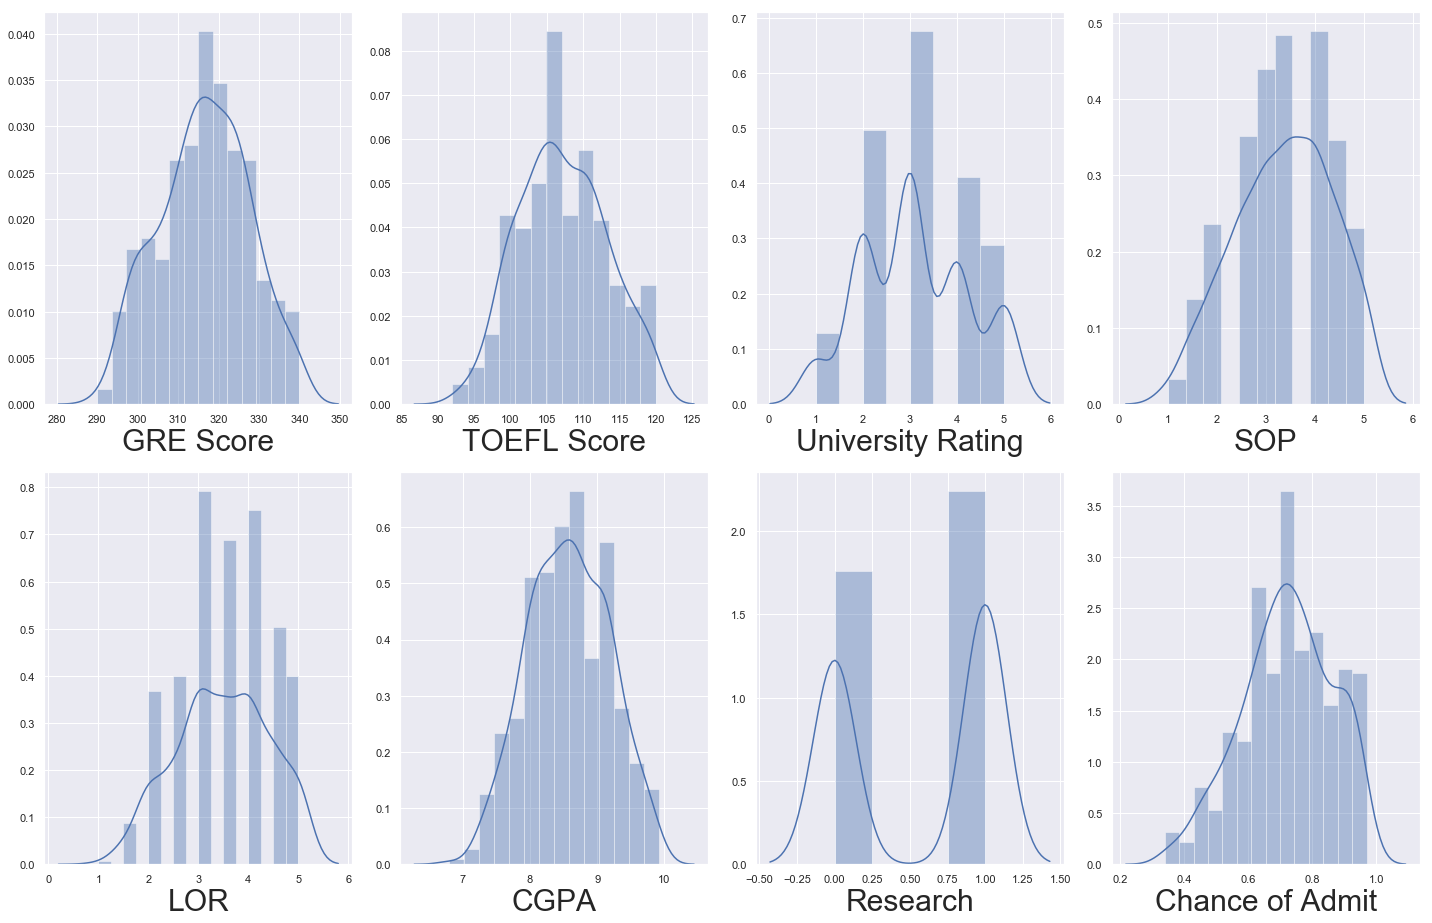

In [39]:
# let's see how data is distributed for every column
plt.figure(figsize = (20,25),facecolor = 'white')
pltnumber = 1


for column in data:
    if pltnumber<=16:
        ax = plt.subplot(4,4,pltnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize= 30)
        pltnumber+=1
plt.tight_layout()



The data distribution looks decent enough and there doesn't seem to be any skewness. Great let's go ahead!

Let's observe the relationship between independent variables and dependent variable.

In [42]:
y = data['Chance of Admit']
X = data.drop(columns= ['Chance of Admit'])

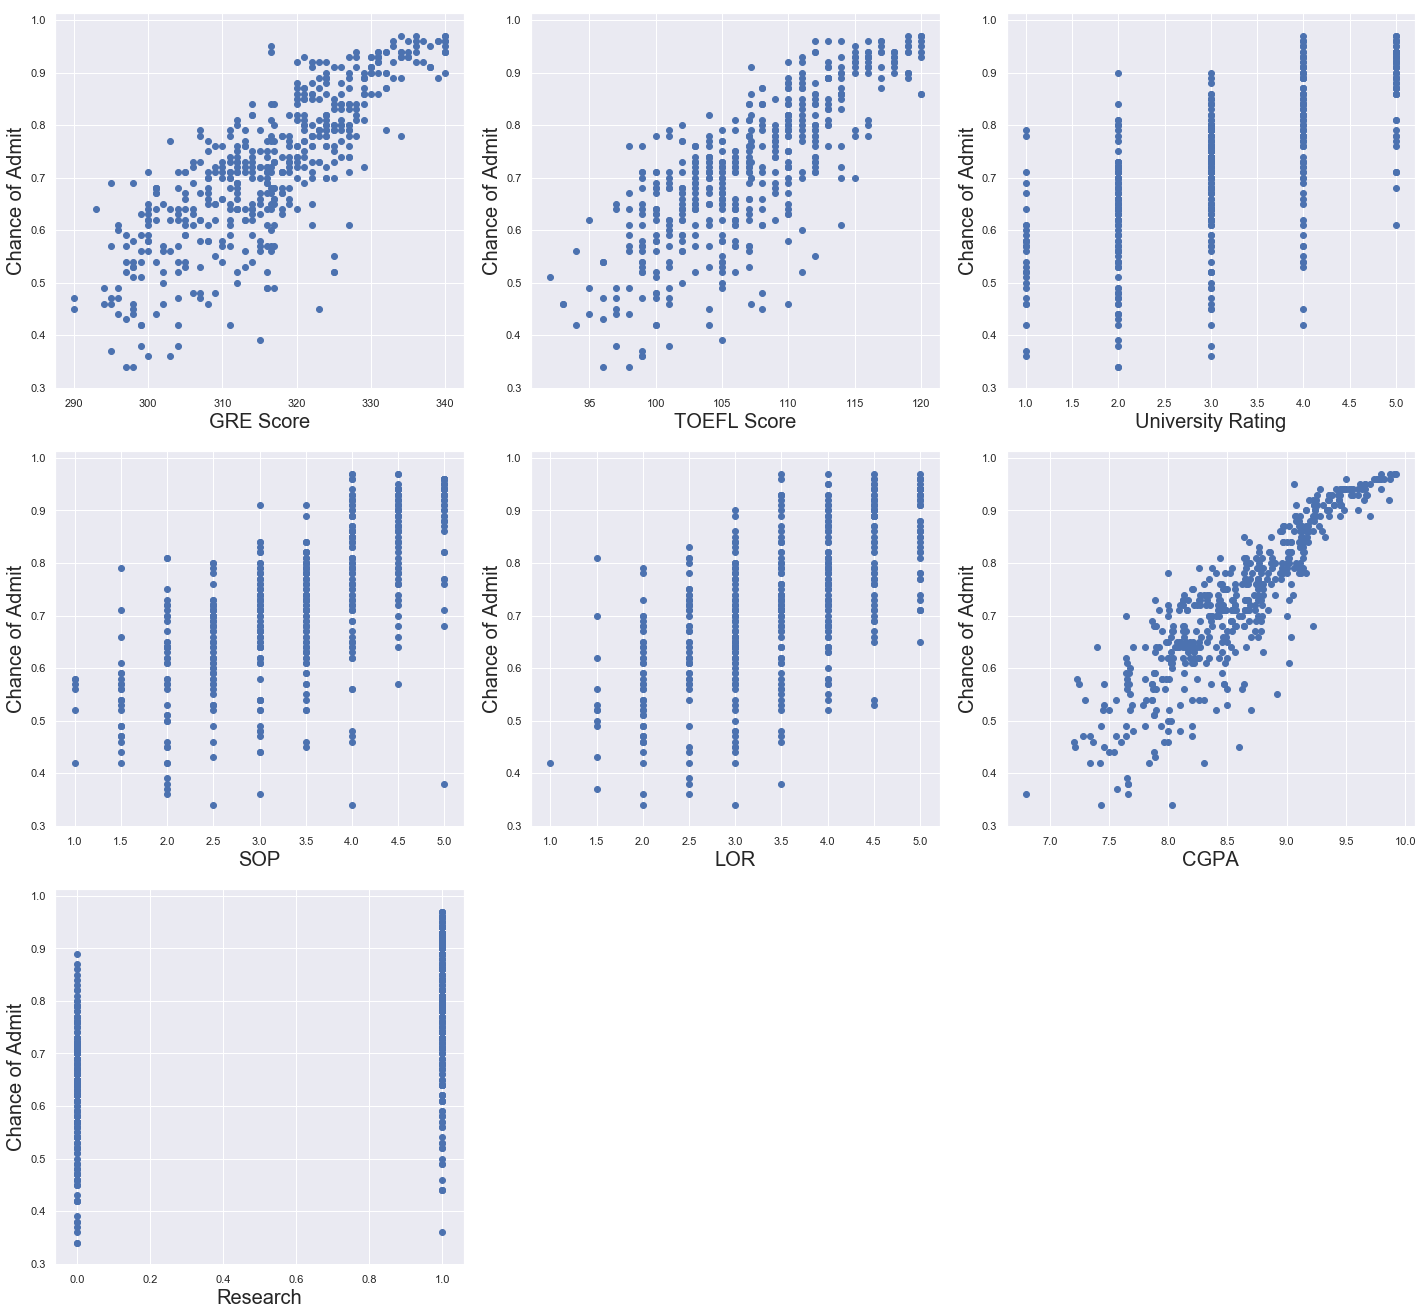

In [43]:
plt.figure(figsize=(20,30), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=15 :
        ax = plt.subplot(5,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Chance of Admit',fontsize=20)
    plotnumber+=1
plt.tight_layout()


Great, the relationship between the dependent and independent variables look fairly linear. Thus, our linearity assumption is satisfied.

Let's move ahead and check for multicollinearity.

In [50]:
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X)

C:\Users\mukchand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mukchand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_Scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do

vif = pd.DataFrame()
# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables,i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns
vif



,VIF,Features
0,4.152735,GRE Score
1,3.793345,TOEFL Score
2,2.517272,University Rating
3,2.776393,SOP
4,2.037449,LOR
5,4.654369,CGPA
6,1.459411,Research


Here, we have the correlation values for all the features. As a thumb rule, a VIF value greater than 5 means a very severe multicollinearity. We don't any VIF greater than 5 , so we are good to go.

Great. Let's go ahead and use linear regression and see how good it fits our data. But first. let's split our data in train and test.

In [57]:
x_train,x_test,y_train,y_test = train_test_split(X_Scaled,y,test_size = 0.25,random_state = 355)

In [58]:
regression = LinearRegression()
regression.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
intercept = regression.intercept_
Coef = regression.coef_
print('Intercept is: ' +  str(intercept))
print('Coeff is: ' +  str(Coef))

Intercept is: 0.7232045728172708
Coeff is: [0.02337531 0.01126961 0.00431843 0.00142731 0.01481975 0.07883426
 0.00987942]


In [66]:
# saving the model to the local file system
import pickle
FileName = 'FirstLinearRegressionModel.pickle'
pickle.dump(regression,open(filename,'wb'))



NameError: name 'filename' is not defined

In [70]:
score = regression.score(x_train,y_train)
score

0.8415250484247909

In [73]:
adj_r2(x_train,y_train)

0.8385023654247188

Our r2 score is 84.15% and adj r2 is 83.85% for our training et., so looks like we are not being penalized by use of any feature.

Let's check how well model fits the test data.

Now let's check if our model is overfitting our data using regularization.

In [74]:
regression.score(x_test,y_test)

0.7534898831471067

In [75]:
adj_r2(x_test,y_test)

0.7387414146174465

So it looks like our model r2 score is less on the test data.

Let's see if our model is overfitting our training data.

In [77]:
# Lasso Regularization
# LassoCV will return best alpha and coefficients after performing 10 cross validations
lasscv = LassoCV(alphas=None,cv = 10,max_iter=100000,normalize= True)
lasscv.fit(x_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [78]:
# best alpha parameter
alpha = lasscv.alpha_
alpha

3.0341655445178153e-05

In [79]:
#now that we have best parameter, let's use Lasso regression and see how well our data has fitted before

lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train,y_train)

Lasso(alpha=3.0341655445178153e-05, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
lasso_reg.score(x_test,y_test)

0.7534654960492284